In [1]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from skimage.util import view_as_windows

from framework.pixelhop import *
from framework.utils import *

from skimage.measure import block_reduce
import xgboost as xgb
import warnings, gc
import time
import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.__version__)

import os
print(os.getcwd())

from framework.dftloss import *

True
1
1.13.0
/media/hongyu/SSD/SSDUBUNTU/WUSL/Pixelhop-Pytorch


In [2]:

import lightgbm as lgb
import math
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn


# ---------- Load MNIST data and split ----------
(x_train, y_train), (x_test,y_test) = cifar10.load_data()
# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')
x_test = np.asarray(x_test,dtype='float32')
y_train = np.asarray(y_train,dtype='int')
y_test = np.asarray(y_test,dtype='int')
print("training with input:", x_train.shape)


CIFAR10NAMES = [
"airplane", #0
"automobile", #1
"bird", #2 
"cat", #3
"deer", #4
"dog", #5
"frog", #6
"horse", #7
"ship", #8
"truck" #9
]


training with input: (50000, 32, 32, 3)


# Data

In [42]:
# ---------- Load MNIST data and split ----------
(x_train, y_train), (x_test,y_test) = cifar10.load_data()
# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')
x_test = np.asarray(x_test,dtype='float32')
y_train = np.asarray(y_train,dtype='int')
y_test = np.asarray(y_test,dtype='int')
print("training with input:", x_train.shape)

# brutal force flip augmentation of trianing data:
Xtrain = []
for img in x_train:
    
    imgflip = cv2.flip(img,1)
    Xtrain.append(imgflip)
    
Xtrain = np.array(Xtrain)
print(Xtrain.shape)

Xtrain = np.concatenate((Xtrain,x_train),axis=0)
print(Xtrain.shape)

Ytrain = np.concatenate((y_train,y_train),axis=0)

training with input: (50000, 32, 32, 3)
(50000, 32, 32, 3)
(100000, 32, 32, 3)


# Model

In [3]:
SaabArgs = [
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':False, 'cw': False}, # PQR transform in this step
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            # {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True}
            ]

shrinkArgs = [
            # {'func':Shrink, 'win':1, 'pad':true/false, 'stride': 1},
            {'func':NoShrink, 'win':1, 'pad':0, 'stride': 1, 'pooling':0},#PQR
            {'func':Shrink, 'win':5, 'pad':0, 'stride': 1, 'pooling':1,'poolingParms' :(3,2,1)},#conv1
            {'func':Shrink, 'win':5, 'pad':0, 'stride': 1, 'pooling':1,'poolingParms' :(3,2,1)},#conv2
            {'func':Shrink, 'win':5, 'pad':0, 'stride': 1, 'pooling':1,'poolingParms' :(3,2,1)},#conv3
            # {'func':Shrink, 'win':5, 'pad':0, 'stride': 1, 'pooling':0},#conv3
            ]

concatArg = {'func':Concat}

threshold1 = 0.0001 # for splitting, th2 <= kernels <= th1 will be treated as leaf nodes
threshold2 = 0.00005 # for feature selections, discard these kernels directly after each saab training
depth = 4

In [4]:
module_filename = './model/model_d=535.pkl'
mymodel = pickle.load(open(module_filename ,'rb'))
print("model loaded at ", module_filename)

model loaded at  ./model/model_d=535.pkl


# Load previous trained features

In [7]:
# Find features and DFT results from different hops:
feathop3dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/feat_train+test_d=535.pkl'
feathop3 = pickle.load(open(feathop3dir, 'rb'))
feattrain_hop3, feattest_hop3 = feathop3

In [8]:
feathop2dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/feat_train+test_hop2_d=6350.pkl'
feathop2 = pickle.load(open(feathop2dir, 'rb'))
feattrain_hop2, feattest_hop2 = feathop2

In [9]:
feathop1dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/feat_train+test_hop1_d=8232.pkl'
feattrain_hop1, feattest_hop1  = pickle.load(open(feathop1dir, 'rb'))

# Load DFT

In [22]:
DFThop3dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/DFT_Hop3_535.pkl' 
DFThop3, DFThop3_sort_idx, __, __ = pickle.load(open(DFThop3dir, 'rb'))

print(len(DFThop3))

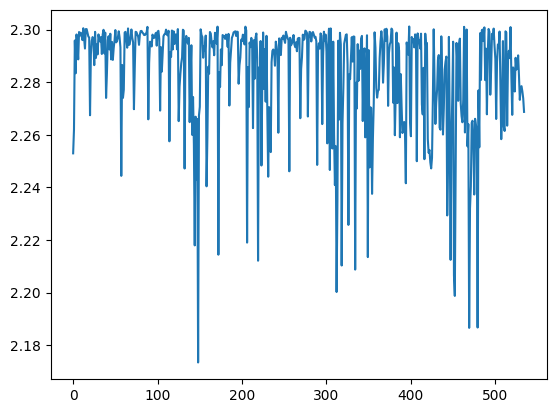

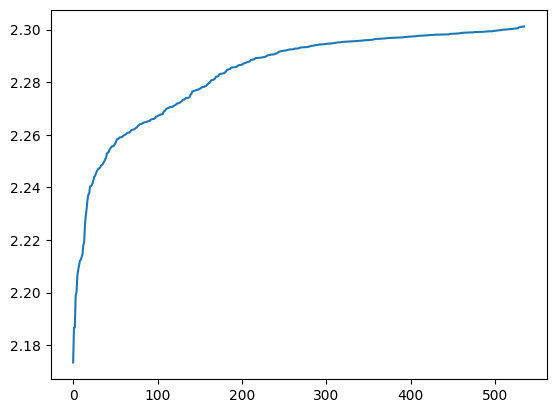

In [19]:
plt.plot(DFThop3)
plt.show()

plt.plot(sorted(DFThop3))
plt.show()

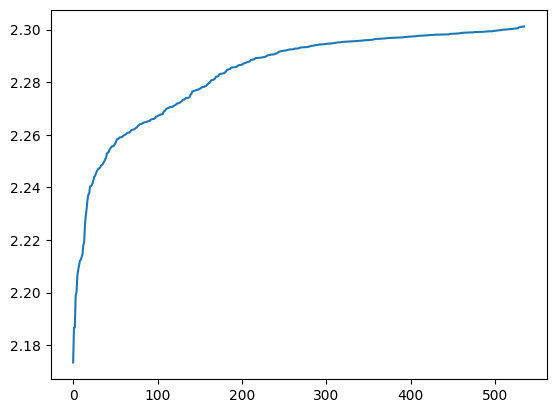

In [24]:
plt.plot(np.array(DFThop3)[DFThop3_sort_idx])
plt.show()


In [29]:
DFThop2dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/DFT_Hop2_6350.pkl' 
DFThop2, DFThop2_sort_idx, __, __ = pickle.load(open(DFThop2dir, 'rb'))

In [30]:
DFThop1dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/DFT_Hop1_8232.pkl' 
DFThop1, DFThop1_sort_idx, __, __ = pickle.load(open(DFThop1dir, 'rb'))

In [47]:
# Try concatenate all and get top features:
# 535, 6350, 8232
featdim = 6000
DFTall = DFThop3 + DFThop2 + DFThop1

print(len(DFTall))

concate_select = np.argsort(DFTall)

feattrain_raw = np.concatenate((feattrain_hop3, feattrain_hop2, feattrain_hop1), axis = 1)
print(feattrain_raw.shape)

feattrain_select1 = feattrain_raw[:,concate_select[:featdim]]
print("selected feature train:")
print(feattrain_select1.shape)

feattest_select1 = np.concatenate((feattest_hop3, feattest_hop2, feattest_hop1), axis = 1)[:,concate_select[:featdim]]
print("selected feature test:")
print(feattest_select1.shape)


15117
(100000, 15117)
selected feature train:
(100000, 6000)
selected feature test:
(10000, 6000)


In [48]:
from sklearn.model_selection import train_test_split

X_fit, X_val, y_fit, y_val = train_test_split(
    feattrain_select1, Ytrain, test_size=0.01, random_state=42)

print("train data:", X_fit.shape, y_fit.shape)
print("val data:", X_val.shape, y_val.shape)

train data: (99000, 6000) (99000, 1)
val data: (1000, 6000) (1000, 1)


train data: (99000, 6000) (99000, 1)
val data: (1000, 6000) (1000, 1)


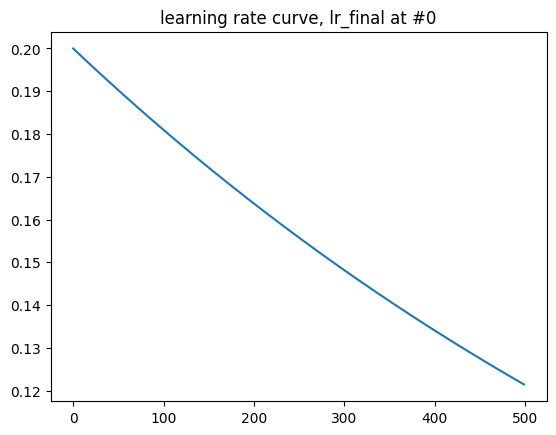

/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[100]	fit's multi_logloss: 0.240388	val's multi_logloss: 0.782103
[200]	fit's multi_logloss: 0.0616161	val's multi_logloss: 0.709194
[300]	fit's multi_logloss: 0.0170968	val's multi_logloss: 0.697964
[400]	fit's multi_logloss: 0.00494383	val's multi_logloss: 0.714887
[500]	fit's multi_logloss: 0.00146815	val's multi_logloss: 0.744817
training time: 811.1502554416656
Plot metrics recorded during training...


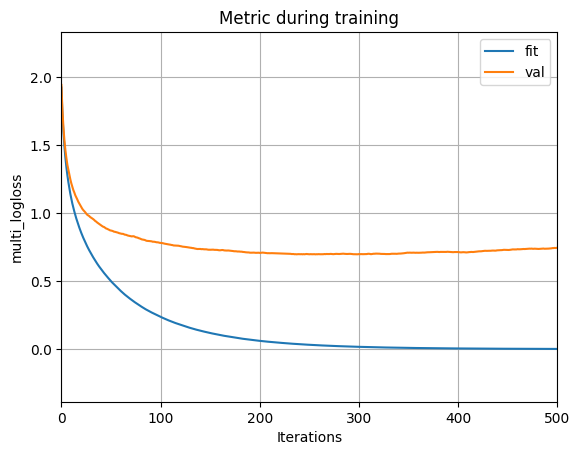

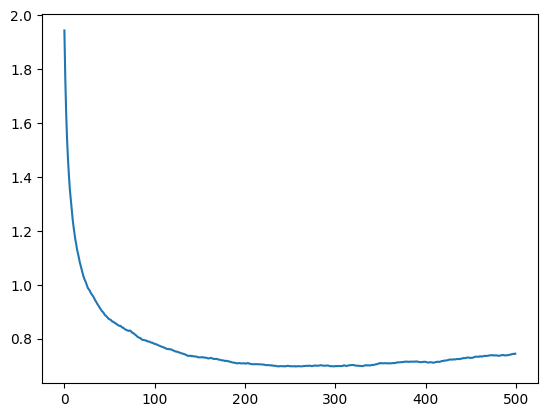

Train Accuary: 100.00%


In [49]:
import lightgbm as lgb
import math
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn

print("train data:", X_fit.shape, y_fit.shape)
print("val data:", X_val.shape, y_val.shape)

fit = lgb.Dataset(
    X_fit, y_fit,
)

val = lgb.Dataset(
    X_val, y_val,
)

maxdepth = 6
lr0 = 0.2 # make sure GD at the begining
lr_final = 0.2 # make sure final converge faster
k = -0.001 # lower -> more smooth
num_rounds = 500
rounds = np.arange(num_rounds)
rounds_lr = lr0 * math.e**(k * rounds)
plt.plot(rounds, rounds_lr)
plt.title("learning rate curve, lr_final at #" + str(int(math.log(lr_final/lr0)/k)) )
plt.show()

evals_result = {} 

t0 = time.time()
model = lgb.train(
    params={
        'learning_rate': 0.1,
        'max_depth': maxdepth,
        # 'num_leaves': 10,
        'device' : 'gpu',
        # 'gpu_platform_id' : 0,
        # 'gpu_device_id' : 0 ,
        # 'num_gpu' : 2,
        'objective': 'multiclass',
        'num_class':10,
        # 'feature_fraction': 0.4,
        # 'bagging_fraction': 0.6,
        # 'bagging_freq': 10,
        'verbose' : -1
           },
    train_set=fit,
    num_boost_round=num_rounds,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    # early_stopping_rounds=200,
    evals_result=evals_result,
    verbose_eval=100,
    # fobj=fl.lgb_obj,
    # feval=fl.lgb_eval,
    callbacks=[lgb.reset_parameter(learning_rate=lambda \
        current_round: max(lr0 * math.e**(k * current_round), lr_final))]
)

print("training time:", time.time()-t0)
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

plt.plot(evals_result['val']['multi_logloss'])
plt.show()

y_preds =model.predict(X_fit)
y_train_preds = []
for x in y_preds:
    y_train_preds.append(np.argmax(x))

y_train_preds = np.array(y_train_preds)

train_accuracy = accuracy_score(y_fit, y_train_preds)
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))


Test Accuary: 74.99%


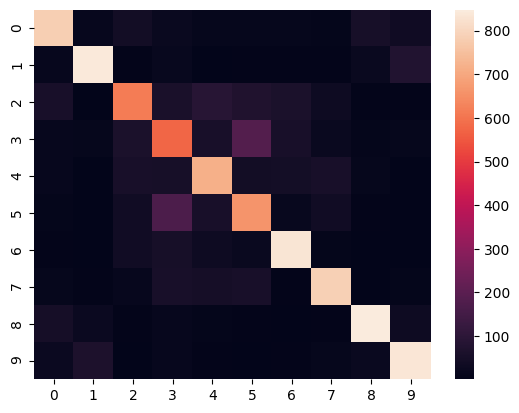

In [50]:
t0 = time.time()
y_test_preds = []
y_preds =model.predict(feattest_select1)
for x in y_preds:
    y_test_preds.append(np.argmax(x))
y_test_preds = np.array(y_test_preds)

pred_accuracy_score = accuracy_score(y_test, y_test_preds)
# pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print("Test Accuary: %.2f%%" % (pred_accuracy_score* 100.0))
# print('inference time:', time.time() - t0)

cnf_matrix = confusion_matrix(y_test, y_test_preds)
df_cm = pd.DataFrame(cnf_matrix)
sn.heatmap(df_cm)
plt.show()